## Option 2 — Search over mixed audio/text using noisy ASR (phoneme 3-grams)

This notebook implements: **g2p_en → phoneme 3-grams → cosine similarity → ranking + bar chart + top overlap**.

- Query is **clean** and has **exactly 4 words**.
- Two docs are clean text; two are ASR-like noisy with controlled corruption of **query words only**.


In [3]:


"""Option 2 (IR): Phoneme 3-gram indexing and retrieval over mixed clean/noisy (ASR-like) text.

Pipeline (kept as required): g2p_en → phoneme 3-grams → cosine similarity → ranking + bar chart + top overlap.

Requirements (in your environment):
  pip install g2p_en matplotlib nltk
"""

from __future__ import annotations

import math
import re
import sys
from collections import Counter
from dataclasses import dataclass
from typing import Iterable, List

import matplotlib.pyplot as plt


try:
    from g2p_en import G2p
except Exception as e:
    print(
        "ERROR: Could not import g2p_en. Install dependencies:\n"
        "  pip install g2p_en nltk matplotlib\n\n"
        f"Details: {e}",
        file=sys.stderr,
    )
    raise


_PUNCT_RE = re.compile(r"[^a-z0-9\s]+", re.IGNORECASE)
_WS_RE = re.compile(r"\s+")


@dataclass(frozen=True)
class Document:
    doc_id: str
    text: str


def normalize_text(text: str) -> str:
    """Lowercase and strip punctuation, then collapse whitespace."""
    text = text.lower()
    text = _PUNCT_RE.sub(" ", text)
    text = _WS_RE.sub(" ", text).strip()
    return text


def _ensure_nltk_data() -> None:
    """Try to download common NLTK resources used by g2p_en if missing (quietly)."""
    try:
        import nltk  # type: ignore

        # g2p_en relies on tokenization + POS tagging; recent NLTK versions
        # may require the *_eng tagger variant. Keep this best-effort and quiet.
        pkgs = (
            "cmudict",
            "punkt",
            "punkt_tab",  # some installs need this
            "averaged_perceptron_tagger",
            "averaged_perceptron_tagger_eng",
        )

        for pkg in pkgs:
            try:
                nltk.data.find(f"corpora/{pkg}")
                continue
            except LookupError:
                pass
            try:
                nltk.data.find(f"tokenizers/{pkg}")
                continue
            except LookupError:
                pass
            try:
                nltk.data.find(f"taggers/{pkg}")
                continue
            except LookupError:
                pass
            try:
                nltk.download(pkg, quiet=True)
            except Exception:
                # Best-effort only.
                pass
    except Exception:
        pass


def text_to_phonemes(text: str, g2p: G2p) -> List[str]:
    """Normalize text, then convert to a filtered phoneme token sequence (ARPAbet-like)."""
    norm = normalize_text(text)
    if not norm:
        return []

    raw = g2p(norm)

    phonemes: List[str] = []
    for tok in raw:
        if not tok or tok.isspace():
            continue
        # Keep ARPAbet-ish tokens, e.g. AH0, N, SH.
        if re.fullmatch(r"[A-Z]+[0-2]?", tok):
            phonemes.append(tok)
    return phonemes


def phoneme_ngrams(phonemes: List[str], n: int = 3) -> List[str]:
    """Generate phoneme n-grams (default: 3-grams) as 'PH1-PH2-PH3' strings."""
    if n <= 0 or len(phonemes) < n:
        return []
    return ["-".join(phonemes[i : i + n]) for i in range(len(phonemes) - n + 1)]


def vectorize(ngrams: Iterable[str]) -> Counter:
    """Convert an iterable of n-grams into a bag-of-ngrams count vector."""
    return Counter(ngrams)


def cosine_similarity(v1: Counter, v2: Counter) -> float:
    """Cosine similarity for sparse count vectors; safe for empty vectors."""
    if not v1 or not v2:
        return 0.0

    dot = 0.0
    # Iterate the smaller vector.
    if len(v1) > len(v2):
        v1, v2 = v2, v1
    for k, c in v1.items():
        dot += c * v2.get(k, 0)

    n1 = math.sqrt(sum(c * c for c in v1.values()))
    n2 = math.sqrt(sum(c * c for c in v2.values()))
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return float(dot / (n1 * n2))


def _snippet(text: str, n: int = 80) -> str:
    t = text[:n]
    return t + ("..." if len(text) > n else "")



## Run: build documents (clean + ASR-noisy), index with phoneme 3-grams, and retrieve


Query (clean): signal processing noise reduction

Documents (normalized snippets):
- D1_clean: this assignment discusses signal processing for audio including noise reduction ...
- D2_clean: we study information retrieval over spoken content signal processing can help wi...
- D3_noisy_asr: this assignment discusses signel processing for audio including noize reduction ...
- D4_noisy_asr: we study information retrieval over spoken content signal proccessing can help w...

Results (ranked by cosine similarity over phoneme 3-grams):
doc_id            score
------------------------
D1_clean         0.5134
D2_clean         0.5000
D3_noisy_asr     0.4682
D4_noisy_asr     0.2609

Top overlap (best doc: D1_clean, score=0.5134)
3-gram                  q   doc  overlap
------------------------------------------
SH-AH0-N                1     2        1
OY1-Z-R                 1     1        1
AH1-K-SH                1     1        1
IH0-NG-N                1     1        1
IH1-G-N                

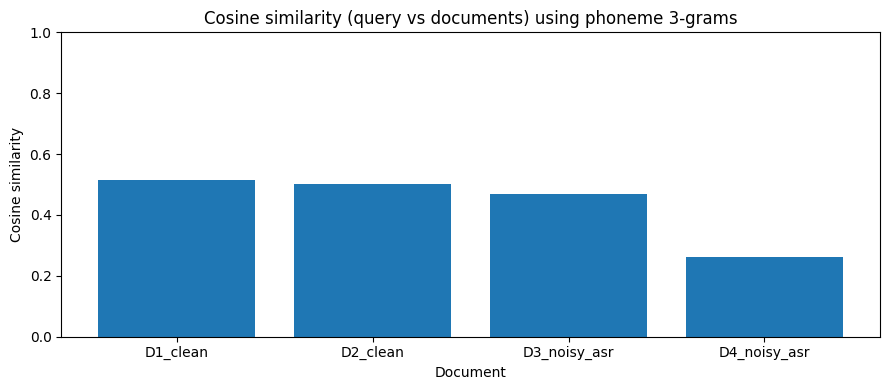

In [4]:
from typing import Dict, Tuple


def main() -> None:
    # Clean query (exactly 4 words; no errors in query)
    query = "signal processing noise reduction"
    assert len(query.split()) == 4, "Assignment requirement: query must contain exactly 4 words"

    # Four documents in-code: 2 clean, 2 ASR-like noisy.
    # ASR errors are injected ONLY in query words, with controlled diversity:
    # - D3_noisy_asr corrupts ONLY TWO query words; keeps the other two correct.
    # - D4_noisy_asr corrupts the OTHER TWO query words; keeps the first two correct.
    documents = [
        Document(
            "D1_clean",
            "This assignment discusses signal processing for audio, including noise reduction "
            "methods and evaluation of retrieval quality.",
        ),
        Document(
            "D2_clean",
            "We study information retrieval over spoken content. Signal processing can help "
            "with noise reduction before indexing.",
        ),
        # D3 corrupts: signal→signel, noise→noize; keeps: processing, reduction
        Document(
            "D3_noisy_asr",
            "This assignment discusses signel processing for audio, including noize reduction "
            "methods and evaluation of retrieval quality.",
        ),
        # D4 corrupts: processing→proccessing, reduction→reduccion; keeps: signal, noise
        Document(
            "D4_noisy_asr",
            "We study information retrieval over spoken content. signal proccessing can help "
            "with noise reduccion before indexing.",
        ),
    ]

    _ensure_nltk_data()
    g2p = G2p()

    print("Query (clean):", query)
    print()

    q_ph = text_to_phonemes(query, g2p)
    q_3g = phoneme_ngrams(q_ph, n=3)
    q_vec = vectorize(q_3g)

    doc_vectors: Dict[str, Counter] = {}
    doc_scores: List[Tuple[str, float]] = []

    print("Documents (normalized snippets):")
    for d in documents:
        norm = normalize_text(d.text)
        print(f"- {d.doc_id}: {_snippet(norm)}")

        d_ph = text_to_phonemes(d.text, g2p)
        d_3g = phoneme_ngrams(d_ph, n=3)
        d_vec = vectorize(d_3g)

        doc_vectors[d.doc_id] = d_vec
        score = cosine_similarity(q_vec, d_vec)
        doc_scores.append((d.doc_id, score))
    print()

    doc_scores.sort(key=lambda x: x[1], reverse=True)

    print("Results (ranked by cosine similarity over phoneme 3-grams):")
    print(f"{'doc_id':<12} {'score':>10}")
    print("-" * 24)
    for doc_id, score in doc_scores:
        print(f"{doc_id:<12} {score:>10.4f}")
    print()

    # Top overlap section for best-ranked document.
    best_doc_id, best_score = doc_scores[0]
    best_vec = doc_vectors[best_doc_id]

    overlap = {k: min(q_vec.get(k, 0), best_vec.get(k, 0)) for k in (q_vec.keys() & best_vec.keys())}
    top_overlap = sorted(
        overlap.items(),
        key=lambda kv: (kv[1], q_vec[kv[0]] + best_vec[kv[0]]),
        reverse=True,
    )[:15]

    print(f"Top overlap (best doc: {best_doc_id}, score={best_score:.4f})")
    if not top_overlap:
        print("- (no overlapping 3-grams)")
    else:
        print(f"{'3-gram':<20} {'q':>4} {'doc':>5} {'overlap':>8}")
        print("-" * 42)
        for gram, ov in top_overlap:
            print(f"{gram:<20} {q_vec[gram]:>4} {best_vec[gram]:>5} {ov:>8}")
    print()

    # Visualization: bar chart of cosine similarity per doc.
    doc_ids = [doc_id for doc_id, _ in doc_scores]
    scores = [score for _, score in doc_scores]

    plt.figure(figsize=(9, 4))
    plt.bar(doc_ids, scores)
    plt.title("Cosine similarity (query vs documents) using phoneme 3-grams")
    plt.xlabel("Document")
    plt.ylabel("Cosine similarity")
    plt.ylim(0.0, 1.0)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

